# 3. Business Intelligence on Oracle OpenWorld & CodeOne Session Speakers

This notebook uses session data from Oracle OpenWorld and CodeOne sessions to investigate a number of questions regarding the speakers at Oracle OpenWorld and CodeOne 2018 conferences. 

The data is loaded from our local data warehouse - the file `oow2018-sessions-wrangled.json` that is produced by the notebook <a href="./2-OOW2018 Session Catalog - Wrangling I - one single, refined, reshaped file.ipynb">2-OOW2018 Session Catalog - Wrangling I - one single, refined, reshaped file.ipynb</a>. 

In this single, consolidated file with session records, the following features are readily available for each session:
<table><tr>
    <td>code</td><td>title</td><td>room</td>
    </tr><tr>
    <td>room capacity</td><td>track</td><td>oracle_yn</td>
    </tr>
    <tr>
    <td>slides_uploaded_yn</td><td>day</td><td>time</td>
    </tr>
    <tr>
    <td>number_of_speakers</td><td>speaker name</td><td>speaker job title</td>
    </tr>
    <tr>
    <td>speaker_company</td><td>speaker designation (Java Champion, ACE Director, JavaOne Rockstart, Groundbreaker Ambassador)</td><td>level (Beginner, Intermediate, Advanced, All)</td>
    </tr>
    <tr>
    <td>event (oow, codeone, both)</td><td>length of session</td><td>session type</td>
    </tr>
    </table>

Some of the questions explored with this notebook:

* <a href="#counting">how many speakers contributed to Oracle OpenWorld and CodeOne? how many to both?</a>
* <a href="#mostactive">which speakers contributed to the largest number of sessions (most active speakers)</a>
* <a href="#jobtitle">what do speakers do in their regular day job: what are the job titles of the speakers?</a>
* <a href="#designation">how many of the speakers have a special designation or title? Are there notable differences across the two events?</a>
* <a href="#company">for which companies are speakers working? How important is the role of Oracle (speakers) in the two conferences?</a>  
* <a href="#names">what are the most popular first names of these speakers?</a>
* <a href="#gender">what is the gender distribution among these speakers? is this distribution different in different tracks or for different levels?</a> 

### <a href="#bonus">Bonus</a>
* how active are speakers in the public domain: github account? twitter? references in bio to blog, book, podcast, conferences
* did speakers tweet about their own sessions (using the session code as a reference)?
* what is the correlation between role, activity on Twitter and GitHub (and perhaps a personal blog) and the special designations of speakers (such as JavaOne Rockstar, ACE Director or Groundbreaker ambassadors)
* do speakers with a special designation get a bigger room assigned than speakers in the same track and the same level without designation? 


## First step: create a Pandas Data Frame for Speaker Records
Using the session data set read from the json file, we will create a data frame with speakers at the heart.

First, load the session data from the file `oow2018-sessions-wrangled.json`.


In [279]:
import pandas as pd
#load session data from JSON file
dataWarehouse = "datawarehouse/"
ss= pd.read_json("{0}oow2018-sessions-wrangled.json".format(dataWarehouse))
#show first five rows in the dataframe
ss.head(5)

,abstract,attributevalues,catalog,code,event,eventCode,files,length,participants,sponsors,...,Advanced,All,track,speaker_count,instance_count,room_capacity,room,day,time,session_timestamp
0,What if you could benefit from new database qu...,"[{'value': 'Beginner', 'attributevalue_id': '1...",oow,TRN4070,Oracle OpenWorld,oow18,"[{'fileId': '1540594881063001PjdE', 'filename'...",45,[{'speakerId': '14574694377280015QNA_150393630...,None,...,Y,Y,"[- Application Development, Oracle Cloud Platf...",3,1.0,308.0,Moscone West - Room 3009,Wednesday,11:15,1.540380e+12
1,How does a real-world performance engineer int...,"[{'value': 'Beginner', 'attributevalue_id': '1...",oow,TRN4026,Oracle OpenWorld,oow18,"[{'fileId': '1540053090863001JeFM', 'filename'...",45,[{'speakerId': '145746969078000151fg_150393630...,None,...,Y,Y,"[- Application Development, Oracle Cloud Platf...",2,1.0,313.0,Moscone West - Room 3004,Monday,15:45,1.540223e+12
10,In this session learn how to make client data ...,"[{'value': 'Beginner', 'attributevalue_id': '1...",oow,TRN6449,Oracle OpenWorld,oow18,"[{'fileId': '1540334126918001DZZj', 'filename'...",45,[{'speakerId': '1500578268510001KsST_150393630...,None,...,Y,Y,[],1,1.0,314.0,Moscone West - Room 3002,Tuesday,15:45,1.540310e+12
100,In this session learn how to transfer your st...,"[{'value': 'Product Training Session', 'attrib...",oow,TRN6527,Oracle OpenWorld,oow18,None,20,[{'speakerId': '14664511836130012Qxc_150393630...,None,...,N,N,[],1,1.0,75.0,The Exchange @ Moscone South - OU Mini Theater,Wednesday,16:25,1.540398e+12
1000,With Java Flight Recorder (JFR) and Java Missi...,"[{'value': 'Intermediate', 'attributevalue_id'...",codeone,DEV5490,Oracle Code One,oow18,None,45,[{'speakerId': '14574694362910015Agr_150393630...,None,...,Y,N,"[Developer Community, Development Tools, Java ...",1,1.0,283.0,Moscone West - Room 2024,Tuesday,11:30,1.540294e+12


In [280]:
#function to derive designation flag from speakers
# values for designation: JavaOne Rockstar, Oracle ACE Director, Oracle Java Champion, Groundbreaker Ambassador, 
def speaker_designation(speakerAttributeValues, designation):
    result = "N"
    # loop over speaker's attributevalues; if any exist with attribute_id == specialdesignations and value == JavaOne Rockstar
    for y in speakerAttributeValues[:]:
          if "attribute_id" in y: 
              if y["attribute_id"]=="specialdesignations":
                  if y["value"]== designation:
                      result="Y"
    return result

def speaker_attribute(speakerAttributeValues, attribute_id):
    result = None
    # loop over speaker's attributevalues; if any exist with attribute_id == specialdesignations and value == JavaOne Rockstar
    for y in speakerAttributeValues[:]:
          if "attribute_id" in y: 
              if y["attribute_id"]== attribute_id:
                  result = y["value"]
    return result

Create the `speakers` Data Frame - derived from the sessions data and with one record per speaker. Note: because speakers can occur multiple times in the sessions data (because they can contribute to multiple sessions), the cell below performs both inserts (the first time we encounter a speaker) and updates (when we next see a speaker again) into the `speakers` data frame. 

In [281]:
## Some Initial Wrangling - Transpose Data - Speakers First
# Let's create a data frame organized by speaker and their primary attributes: firstName, lastName, jobTitle, company,
# number of sessions, special designations, twitter, github, OracleEmployee

designations = ['JavaOne Rockstar', 'Oracle ACE Director', 'Oracle Java Champion', 'Groundbreaker Ambassador']

# Create a dict of dictionaries in which each dictionary corresponds to speaker and the firstname+lastname is the key.
# Create a data frame from the list of dictionaries in this dictionary.
speakers = {}
#iterate over all sessions and for each session over all participants
for index, row in ss.iterrows():
    for speaker in row["participants"]:
        key = speaker['firstName']+'.'+speaker['lastName']
        # check if we already have a row in speaker_list sp with the same firstName and lastName
        skr = speakers.get(key,None)
        if skr==None:
            #obTitle, company, number of sessions, special designations, twitter, github, OracleEmployee
            skr = { 'firstName':speaker['firstName']
                  , 'lastName': speaker['lastName']
                  , 'jobTitle': speaker.get('jobTitle','-')
                  , 'companyName': speaker.get('companyName','-')
                  , 'bio': speaker.get('bio','-')
                  , 'oracle_employee': 'Y' if ("oracle" in speaker.get('companyName','-').lower()) else 'N'
                  , 'photoURL' :  speaker.get('photoURL',None)
                  , 'twitter' :  speaker.get('twitter',None)
                  , 'sessionCount': 1
                  , 'oow': 'Y' if row['event'] == 'Oracle OpenWorld' else 'N'
                  , 'codeone': 'Y' if row['event'] == 'Oracle Code One' else 'N'
                  }
            for d in designations:
                skr[d] = speaker_designation(speaker.get('attributevalues',[]), d)
           
        else: # else is when a speaker is already in the speakers data frame and only should be updated 
            skr['sessionCount']+=1 
            if skr['oow']=='N':
                skr['oow']= 'Y' if row['event'] == 'Oracle OpenWorld' else 'N'
            if skr['codeone']=='N':
                skr['codeone'] =  'Y' if row['event'] == 'Oracle Code One' else 'N'
        speakers[key] = skr
        
# turn the list of speaker dicts - the values in the speakers dict - into a dataframe 
sp = pd.DataFrame(list(speakers.values()))   
sp.head(5)
#sp.info()


,Groundbreaker Ambassador,JavaOne Rockstar,Oracle ACE Director,Oracle Java Champion,bio,codeone,companyName,firstName,jobTitle,lastName,oow,oracle_employee,photoURL,sessionCount,twitter
0,N,N,N,N,Director of Product Management at Oracle cover...,Y,Oracle,Kuassi,"Director, Product Management",Mensah,Y,Y,https://static.rainfocus.com/oracle/oow18/att/...,9,@kmensah
1,N,N,N,N,-,N,Oracle,Srinath,Senior Director,Krishnaswamy,Y,Y,None,1,None
2,N,N,N,N,Kant is Director of Development within Server ...,N,Oracle,Kant,Director,Patel,Y,Y,None,2,None
3,N,N,N,N,A Development Manager within the Real-World Pe...,N,Oracle,Robert,"Software Development Manager, Real World Perfo...",Carlin,Y,Y,None,1,None
4,N,N,N,N,Software engineer within the Real-World Perfor...,N,Oracle,Mihajlo,Consulting Member of Technical Staff,Tekic,Y,Y,None,1,None


<a name="counting"/>

# Counting Speakers
Let's start with a few simple questions. How many different speakers contributed to the sessions at Oracle OpenWorld and CodeOne in total? How many participated in both events? 

We will first learn the number of speaker records. Then we will count the speakers per event they contribute to - and present those findings in a cross table.

In [282]:
# quickest way to get your bearings around a data frame: learn number of rows (number of speaker records) and number of columns
sp.shape

(2582, 15)

In [283]:
# number of speakers on each event
#Show the count for various combinations of speakers presenting at OOW and presenting at CodeOne and at both
summ = sp.groupby(['oow', 'codeone']).size().reset_index(name='counts')
summ

,oow,codeone,counts
0,N,Y,383
1,Y,N,2108
2,Y,Y,91


In [284]:
# or use crosstab as an easier way to present two-dimensional counts in a cross table 
pd.crosstab(sp.oow, sp.codeone)

codeone,N,Y
oow,,
N,0,383
Y,2108,91


Anything well represented in a 2x2 cross tab lends itself to visualization in a Venn diagram. Let's create one for the speaker count. This makes the information more easily digestable for us humans. 

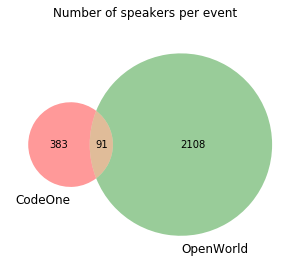

In [285]:
import matplotlib.pyplot as plt
# see https://pypi.org/project/matplotlib-venn/ 
from matplotlib_venn import venn2
# the next line is for making the output from matplotlib appear inline in the notebook
%matplotlib inline
 
venn2( subsets = ( summ.loc[0]['counts']  #YN - CodeOne and not OOW 
                 , summ.loc[1]['counts']  #NY - not CodeOne and OOW
                 , summ.loc[2]['counts']  #YY - both CodeOne and OOW
                )
     , set_labels = ('CodeOne','OpenWorld' )
     )
plt.suptitle("Number of speakers per event")
plt.show()

<a name="mostactive" />

# Most active speaker with the highest session count

Each speaker record has the feature `sessionCount` that indicates the number of sessions of which the speaker is a participant. The following cell identifies the record in the speakers data frame for which the sessionCount has the highest value:

In [286]:
#highest session count: (see https://stackoverflow.com/questions/15741759/find-maximum-value-of-a-column-and-return-the-corresponding-row-values-using-pan )
# this statement finds the row with the highest value for column sessionCount and subsequently returns the entire row
sp.loc[sp['sessionCount'].idxmax()]

Groundbreaker Ambassador                                                    N
JavaOne Rockstar                                                            N
Oracle ACE Director                                                         N
Oracle Java Champion                                                        N
bio                         J. David Mills – Senior Principal Instructor\n...
codeone                                                                     N
companyName                                                            Oracle
firstName                                                               David
jobTitle                                                                     
lastName                                                                Mills
oow                                                                         Y
oracle_employee                                                             Y
photoURL                    https://static.rainfocus.com/oracle/

We also list the top 5 active speakers by sorting the data frame:

In [287]:
sp[['firstName','lastName','companyName', 'sessionCount']].sort_values('sessionCount',ascending=False,).head(5)

,firstName,lastName,companyName,sessionCount
1682,David,Mills,Oracle,12
351,Maciej,Gruszka,Oracle,11
0,Kuassi,Mensah,Oracle,9
6,Susan,Jang,Oracle,9
569,Pyounguk,Cho,Oracle,9


The two colocated events are likely to have a different active speakers. Let's look at the list of most active speakers by event. Here we can make handy use of interactive widget set called *ipywidgets*. These widgets render controls that the consumer of the notebook can use to toggle data filters or other parameters used in selecting, processing and presenting the data.

The next function has been decorated with the `@interact` annotation. As a result, each of its input parameters is rendered as an interactive control - by default a dropdown list. The array in the parameter's definition sets the values shown in the dropdown list.

Note that any active speakers who present on both OOW and CodeOne can show up in both cases.

In [288]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
# here is my source for getting started with interactive widgets: https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6

@interact
def activeSpeakers( event=['oow','codeone']):
    return sp[sp[event]== 'Y'][['firstName','lastName','companyName', 'sessionCount']].sort_values('sessionCount',ascending=False,).head(5)
    
tmp = activeSpeakers('codeone')

interactive(children=(Dropdown(description='event', options=('oow', 'codeone'), value='oow'), Output()), _dom_…

It turns out that most slots are allocated to speakers employed by Oracle. We can of course check for activity by speakers from other companies as well. 

In [289]:
# find most active speakers who do not work for Oracle
# first, filter to retain speakers not working for Oracle, then sort these speakers by session count
sp[sp['companyName']!='Oracle'][['firstName','lastName','companyName', 'sessionCount']].sort_values('sessionCount',ascending=False,).head(5)

,firstName,lastName,companyName,sessionCount
87,Erik,Benner,"Mythics, Inc.",6
818,Lucas,Jellema,AMIS Services BV,6
1065,Trisha,Gee,JetBrains,6
68,Sebastian,Daschner,Sebastian Daschner - IT-Beratung,6
1237,Steve,Poole,IBM,5


<a name="jobtitle" />

## Job Titles for the speakers
What are the daily activities of the speakers? What roles do they play in their day jobs? We know the job title for each speaker. We can take a quick look at popular job titles.

Note: spaces in job titles, such as 'product manager'. The word cloud geenrator does not handle these spaces well, that's why we simply remove the spaces. 

In [290]:
jobTitles = sp['jobTitle'].str.replace(" ", "")
jobTitles.value_counts().head(15)

                                    182
CEO                                  51
Director                             50
-                                    45
ConsultingMemberofTechnicalStaff     30
VicePresident                        29
SeniorPrincipalProductManager        27
CTO                                  26
PrincipalProductManager              25
SeniorDirector                       23
SoftwareEngineer                     23
SeniorSoftwareEngineer               21
ManagingDirector                     20
ProductManager                       18
SeniorDirector,ProductManagement     18
Name: jobTitle, dtype: int64

The next cell presents a word cloud based on the frequency of job titles. In this case, you can toggle between speakers for OpenWorld and for CodeOne. The difference in job titles is telling.

In [291]:
# wordcloud on jobTitle
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

@interact
def jobTitleWordCloud(event=['oow','codeone']):
    wc=WordCloud(use_tfidf=False)
 
    #don't randomize color, show only top 40; for first 2500 speakers
    embed_code=wc.get_embed_code(text=sp[sp[event]=='Y']['jobTitle'].str.replace(" ", "")[:2500],random_color=False,topn=40)
    return HTML(embed_code)
    
tmp = jobTitleWordCloud('oow')    

interactive(children=(Dropdown(description='event', options=('oow', 'codeone'), value='oow'), Output()), _dom_…

<a name="designation" />

## Designations of Speakers
Individualspeakers can be special in many ways. One of the ways is their membership of special programs such as the Oracle ACE Director program, the Java Champions program and the relatively new Groundbreaker Ambassador program. Each of these special designations is indicated in each speaker record through a feature. We can quickly find out how many of the speakers have no designation at all - or any specific combination of designations. The next cell produces that insight. Note how there is one speaker who has all four designations!  

In [292]:
sp.groupby(['JavaOne Rockstar', 'Oracle ACE Director', 'Oracle Java Champion', 'Groundbreaker Ambassador']).size().reset_index(name='counts')

,JavaOne Rockstar,Oracle ACE Director,Oracle Java Champion,Groundbreaker Ambassador,counts
0,N,N,N,N,2392
1,N,N,N,Y,18
2,N,N,Y,N,28
3,N,N,Y,Y,11
4,N,Y,N,N,46
5,N,Y,N,Y,11
6,Y,N,N,N,33
7,Y,N,N,Y,3
8,Y,N,Y,N,22
9,Y,N,Y,Y,16


Sometimes the question is asked whether you need to be an Oracle ACE Director in order to become a Groundbreaker Ambassador or whether being a Java Champion is a prerequisite. We can check with a special types of Venn Diagram how the speakers with a special designation relate to each of the programs. 

Spoiler: It turns out that most Groundbreaker Ambassador have a background as Java Champion and relatively few as Oracle ACE Directory.

In [293]:
summ = sp.groupby([ 'Oracle ACE Director', 'Oracle Java Champion', 'Groundbreaker Ambassador']).size().reset_index(name='counts')
summ

,Oracle ACE Director,Oracle Java Champion,Groundbreaker Ambassador,counts
0,N,N,N,2425
1,N,N,Y,21
2,N,Y,N,50
3,N,Y,Y,27
4,Y,N,N,46
5,Y,N,Y,12
6,Y,Y,Y,1


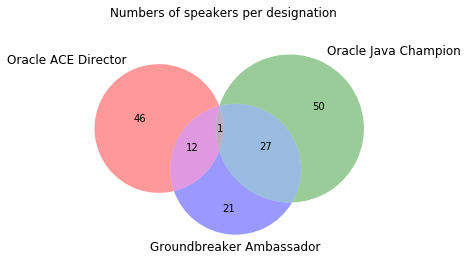

In [294]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
# the next line is for making the output from matplotlib appear inline in the notebook
%matplotlib inline
 
v=venn3(subsets = ( summ.loc[4]['counts'] # YNN
                  , summ.loc[2]['counts'] # NYN
                  , 0 # YYN
                  , summ.loc[1]['counts'] # NNY
                  , summ.loc[5]['counts'] # YNY
                  , summ.loc[3]['counts'] # NYY
                  , summ.loc[6]['counts'] # YYY
                  )
        , set_labels = ('Oracle ACE Director','Oracle Java Champion', 'Groundbreaker Ambassador' ))
plt.suptitle("Numbers of speakers per designation")
plt.show()

<a name="company" />

## Companies for which Speakers are working
Speakers indicate the company they work for. So we can explore a little which companies are represented by speakers at these conferences. 

### Number of speakers per company
Quick evaluation of the numbers of speakers per company. Note: this is not the same as the number of sessions; that can be derived by summing the session_count per speaker

In [295]:
#other companies:
# details on value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html 
sp.companyName.str.upper().value_counts().head(15)

ORACLE                     1179
DELOITTE CONSULTING LLP      32
IBM                          22
RED HAT                      20
ACCENTURE                    14
INFOSYS LIMITED              11
WELLS FARGO                  10
KPMG LLP                     10
PWC                           8
GE                            8
QUEST ORACLE COMMUNITY        8
ORACLE                        6
MICROSOFT                     6
TOMITRIBE                     6
COGNIZANT                     6
Name: companyName, dtype: int64

When you check the website for the Oracle OpenWorld Conference, it is easy to find out which companies are sponsors: 
* sponsors for Oracle OpenWorld: *Intel, Cognizant, Deloitte, Accenture, DXC.Technology, PWC, Tata Consultancy Services, Wipro, Hitachi, KPMG, InfoSys*
* CodeOne sponsors: *IBM, RedHat, PluralSight, Cloud Native Compute Foundation*

It is not farfetched to assume that as part of a sponsorship, companies get a number of slots at the conference. In the next list of active companies, we filter out the sponsors as well as Oracle itself. The resulting set could be regarded as the list of companies that have acquired slots on the true merit of their speakers. We see here the companies and the number of employees who speak at one of the conferences. 

In [296]:
#other companies besides the sponsors:
sponsors = ['ORACLE', 'RED HAT','PWC', 'ACCENTURE','COGNIZANT','IBM','TATA CONSULTANCY SERVICES LTD', 'DELOITTE CONSULTING LLP', 'KPMG LLP' ,'INFOSYS LIMITED' ]

sp[~sp['companyName'].str.upper().isin(sponsors)]['companyName'].value_counts().head(15)

Wells Fargo                            9
GE                                     8
Quest Oracle Community                 8
Tomitribe                              6
Oracle                                 6
Grant Thornton LLP                     6
Microsoft                              5
Western Digital                        5
Google                                 5
Capgemini UK Plc                       4
Edgewater Technology - Ranzal, Inc.    4
CSS International, Inc                 4
Viscosity North America                4
Pythian                                4
Gap Inc.                               4
Name: companyName, dtype: int64

Show the sum of the numbers of sessions for the speakers per company - and leave out the sponsors.

Note: this list can contain double counts - when multiple speakers for a company are active in the same session, that session is counted multiple times.

In [297]:
#other companies besides the sponsors:
sponsors = ['ORACLE', 'RED HAT','PWC', 'ACCENTURE','COGNIZANT','IBM','TATA CONSULTANCY SERVICES LTD', 'DELOITTE CONSULTING LLP', 'KPMG LLP' ,'INFOSYS LIMITED' ]

sp[~sp['companyName'].str.upper().isin(sponsors)].groupby(['companyName'])['sessionCount'].agg('sum').reset_index(name='counts').sort_values('counts',ascending=False,).head(10)

,companyName,counts
876,Tomitribe,15
362,GE,11
493,JetBrains,9
952,Wells Fargo,9
654,Oracle,9
711,Quest Oracle Community,9
598,"Mythics, Inc.",8
172,Capgemini UK Plc,8
886,Trivadis AG,8
936,Viscosity North America,8


We have seen that the number of speakers that work for Oracle is substantial. Let's look at how substantial that number really is - by checking the percentages of Oracle employed speakers for both conferences. 

In [298]:
def conference_for_speaker(speaker):
    return 'both' if speaker['oow']=='Y' and speaker['codeone']=='Y' else 'oow' if speaker['oow']=='Y' else 'codeone' 
                
# derive a single conference feature for all speakers
sp['conference'] = sp.apply(conference_for_speaker, axis=1)
# create a crosstab for conference and gender
pd.crosstab(sp['conference'], sp['oracle_employee']).apply(lambda r: 100*r/r.sum(), axis=1).round(0)

oracle_employee,N,Y
conference,,
both,31.0,69.0
codeone,78.0,22.0
oow,50.0,50.0


Time for a visualization. In a stacked barchart we will compare the numbers of speakers associated with each conference - and we show the numbers of speakers working for Oracle. 

In [299]:
#stackchart
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#this line makes plotly work in offline mode (i.e. not connected to PlotLy cloud) and inside running Jupyter Notebook
plotly.offline.init_notebook_mode(connected=True)

summ = sp.groupby(['oow', 'codeone','oracle_employee']).size().reset_index(name='counts')
# if you would like to see the contents of variable summ, the uncomment the next line
# print(summ)

nonOracleStack = go.Bar(
    x=['CodeOne', 'Oracle OpenWorld'],
    y=[summ.loc[0]['counts'], summ.loc[2]['counts']+summ.loc[5]['counts']],
    name='Non Oracle Staff'
)
OracleStack = go.Bar(
    x=['CodeOne', 'Oracle OpenWorld'],
    y=[summ.loc[1]['counts'], summ.loc[3]['counts']+summ.loc[5]['counts']],
    name='Oracle Employees'
)

data = [nonOracleStack, OracleStack]
layout = go.Layout(
    barmode='stack',
    title='Number of Speakers at Oracle OpenWorld and CodeOne - both Oracle employees and non-Oracle staff'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='stacked-bar')

<a name="names" />

## Popular First Names for Speakers
Let us investigate the hugely important question of what are the top 10 first names for the speakers.

In [300]:
# details on value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html 
sp['firstName'].value_counts().head(10)

David      43
Michael    39
John       39
Chris      28
Mark       25
Scott      23
Mike       23
Brian      17
Alex       17
Paul       16
Name: firstName, dtype: int64

In [301]:
#check for popularity of first names of speakers per event
@interact
def first_names(event=['oow','codeone']):
    return sp[sp[event]=='Y'].groupby([ 'firstName']).size().reset_index(name='counts').sort_values('counts',ascending=False,).head(10)

tmp = first_names('oow') 

interactive(children=(Dropdown(description='event', options=('oow', 'codeone'), value='oow'), Output()), _dom_…

In [302]:
# create a word_cloud 
# leveraging this article: http://kavita-ganesan.com/word-cloud-for-data-scientists/#.XD2JQVxKhPY
# and this github repo: https://github.com/kavgan/word_cloud 
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

wc=WordCloud(use_tfidf=False)
 
#don't randomize color, show only top 40
embed_code=wc.get_embed_code(text=sp['firstName'],random_color=False,topn=40)
HTML(embed_code)

<a name="gender"/>

## Women in Tech - Gender of Speakers

It is interesting to know if women appear as speakers at the two events - given our strive for *more women in tech*. 

We may be able to stimulate the participation of women if we better understand what type of event attracts female speakers and which tracks perhaps have a higher than average percentage of female speakers.

However: our data set does not contain ant straightforward gender information. Gender is not a feature of our speaker records. 

Does our exploration end before it event started - for lack of data? Or can we be creative? Perhaps we can guess the gender from the first name feature that we do have for all speakers. Additionally, we have a biography for each speaker and in these texts speakers frequently describe themselves in the third person - using references to *he* or *she*, *his* and *him* or *her*. So we have at least two clues as to the gender of speakers. Not enough to base any important analysis or individual approach on, but it will do for this high over analysis.

### Deriving Gender from First Name

We can use an API or library for guessing the gender of the speaker based on the first name:
* https://genderize.io/ (1000 calls per day are free)
* https://gender-api.com/ - paid for
* https://pypi.org/project/gender-guesser/ - local libray
* see article for broader overview of this challenge: https://gender-gap-in-science.org/2018/07/16/telling-the-gender-from-a-name/ 


Note: in our case, we are interested in the big picture. Guessing the wrong gender in a few percent of the cases is acceptable. So let's go with the easy to use and fully free gender-guesser library.


In [303]:
import gender_guesser.detector as gender

d = gender.Detector()

@interact_manual
def genderGuesser( name="Jan"):
    print("The Gender Guess is ",d.get_gender(name))

genderGuesser()    

interactive(children=(Text(value='Jan', description='name'), Button(description='Run Interact', style=ButtonSt…

The Gender Guess is  male


Let's derive a new *gender* feature for all our speakers using this library. It will not be perfect it will not be complete, but we will get a first stab at the gender distribution.

In [304]:
sp['gender'] = sp['firstName'].apply(lambda name: d.get_gender(name))
# look at some of the results
sp['gender'][:10]

0    unknown
1    unknown
2       male
3       male
4       male
5       male
6     female
7       male
8    unknown
9     female
Name: gender, dtype: object

What are some of these first names that have stymied our gender guesser library?

In [305]:
sp[sp['gender']=='unknown']['firstName'][:10]

0           Kuassi
1          Srinath
8            Eggie
19           Gabby
26    Ivan Junckes
27         Per-Ake
33           Elder
38          Kishor
41          Pratik
52        Sungpack
Name: firstName, dtype: object

Show the gender values derived by the Gender Guesser and the numbers of instances of each:

In [306]:
# or to be more specific:
sp['gender'].value_counts()

male             1573
unknown           512
female            300
mostly_male       126
mostly_female      45
andy               26
Name: gender, dtype: int64

That is a pretty high number stil of unknowns. Can we improve our data set? 

In the next cell, we ook at all biographies for the speakers with current gender values of *unknown* and *andy* to check for gender specific words such as 'his, he or him' and 'she or her' - and set those gender values based on that. 

Alternatively or additionally, we can call the gender REST APIs as listed above - if we really need our gender data to be of higher quality. Or we could try to leverage an image recognition solution powered by machine learning to classify the speaker pictures by gender.

In [307]:
#check on gender from bio for all speakers where we have not yet derived male or female

genders = ['male','female']

# this function derives gender 
def gender_guess_from_text(bio):
    
    result = "unknown"
    genderTermsToCheck = [' him ', ' his ', ' he ','His ','He ']
    # if bio contains he, his or him - we go with male
    if any(term in bio for term in genderTermsToCheck):
        result = "male"
    # if bio contains she or her - we go with female
    genderTermsToCheck = [' she ', ' her ','She','Her ']
    if any(term in bio for term in genderTermsToCheck):
        result = "female"
    # if neither - we stick to unknown
    return result

def gender_for_speaker(speaker):
    result = speaker['gender']
    # for any speaker whose gender is currently not male or female, let's try to do better
    if speaker['gender'] not in genders:
        result = gender_guess_from_text(speaker['bio']) 
    return result

sp['gender'] = sp.apply(gender_for_speaker, axis=1)

#percentages per gender based after interpreting the biographies
sp['gender'].value_counts(normalize=True) * 100


male       71.456235
unknown    15.182029
female     13.361735
Name: gender, dtype: float64

Leveraging the biographies has helped a little bit, but not all that much to be honest.

With the gender derivation we have tried so far, let's see where we stand - in a Pie Chart for example.

In [308]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import pandas as pd
import numpy as np

#this line makes plotly work in offline mode (i.e. not connected to PlotLy cloud) and inside running Jupyter Notebook
plotly.offline.init_notebook_mode(connected=True)

labels = sp['gender'].value_counts(normalize=True).index
values = sp['gender'].value_counts(normalize=True).values
trace = go.Pie(labels=labels, values=values, title="Gender distribution for speakers")
plotly.offline.iplot([trace], filename='basic_pie_chart')

How is the distribution of the genders when we compare the two events?

In [309]:
def conference_for_speaker(speaker):
    return 'both' if speaker['oow']=='Y' and speaker['codeone']=='Y' else 'oow' if speaker['oow']=='Y' else 'codeone' 
                
# derive a single conference feature for all speakers
sp['conference'] = sp.apply(conference_for_speaker, axis=1)
# create a crosstab for conference and gender
pd.crosstab(sp['conference'], sp['gender']).apply(lambda r: 100*r/r.sum(), axis=1).round(0)

gender,female,male,unknown
conference,,,
both,4.0,90.0,5.0
codeone,11.0,81.0,7.0
oow,14.0,69.0,17.0


One of those extremely relevant questions: do male and female speakers behave the same when it comes to uploading their photograph? 

Surprisingly, the *unknown* category is far more enthusiastic in sending in their picture.

In [310]:
# male and female are behaving the same when it comes to uploading their photograph; surprisingly, the unknown category is far more enthusiastic in sending in their picture
pd.crosstab( sp['gender'], sp['photoURL'].isnull()).apply(lambda r: 100*r/r.sum(), axis=1).round(0)

photoURL,False,True
gender,,
female,73.0,27.0
male,74.0,26.0
unknown,47.0,53.0


<a name="bonus" />

# Bonus Explorations
Below some bonus exploration of the speaker data. For example on words frequently used in speaker biographies. And on the photographs that speakers are expected to upload.

## Popular terminology in speaker Biographies
What are the words used by speakers when they craft their biographies? Can we find common themes? Typical wording? Can we learn how to write a distinctive biography for ourselves - or do we not feel any need to stand out?

In [311]:
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "said","you", "your", "yours", "yourself",
    "yourselves","his","he","she","of","many","the","in","to","is","on","several","com"
    ,"that","prior","more","over","it","was","currently","years","20","since"])

wc=WordCloud(use_tfidf=False,stopwords=ENGLISH_STOP_WORDS)
 
#don't randomize color, show only top 50; for first 2500 speakers
embed_code=wc.get_embed_code(text=sp['bio'][:2500],random_color=False,topn=50)
HTML(embed_code)

<a name="gender"/>

## One picture and a 1000 words - Speaker Photo provided?
Each speaker is requested to upload her or his photograph. The question at hand is whether people have obliged - or could not be bothered. We will also explore the use of  pictures in a Jupyter Notebook a little.

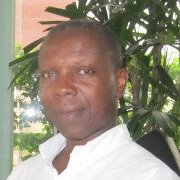

In [312]:
sp.loc[0]['photoURL']
from IPython.display import Image
Image(sp.loc[0]['photoURL'])


In [313]:
#how many speakers provided their picture/how many did not?
#this statements counts the number of null values for each column
sp.isnull().sum()

Groundbreaker Ambassador       0
JavaOne Rockstar               0
Oracle ACE Director            0
Oracle Java Champion           0
bio                            0
codeone                        0
companyName                    0
firstName                      0
jobTitle                       0
lastName                       0
oow                            0
oracle_employee                0
photoURL                     777
sessionCount                   0
twitter                     2173
conference                     0
gender                         0
dtype: int64

In [314]:
# would Oracle employees be more or less forthcoming than non Oracle staff regarding their photo?
# here we show the percentages of Non Oracle Employees and Oracle staff that did not and did submit a photograph
# (it is somewhat disappointing for both cohorts, but especially for the non-Oracle employees; why would that be?)
pd.crosstab(sp['oracle_employee'],sp['photoURL'].isnull()).apply(lambda r: 100*r/r.sum(), axis=1).round(0)

photoURL,False,True
oracle_employee,,
N,78.0,22.0
Y,61.0,39.0


In [315]:
#would Oracle employees be more or less forthcoming than non Oracle staff regarding their photo?

summ = sp.groupby([sp['photoURL'].isnull(),'oracle_employee']).size().reset_index(name='counts')
summ

,photoURL,oracle_employee,counts
0,False,N,1076
1,False,Y,729
2,True,N,311
3,True,Y,466


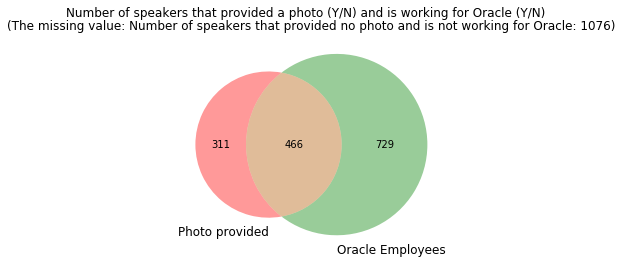

In [316]:
#in a Venn diagram the collections of 'photo provided' and 'Oracle employee'
# Import the library
import matplotlib.pyplot as plt
# see https://pypi.org/project/matplotlib-venn/ 
from matplotlib_venn import venn2
# the next line is for making the output from matplotlib appear inline in the notebook
%matplotlib inline
 
venn2(subsets = (summ.loc[2]['counts'] #YN 
                 , summ.loc[1]['counts']  #NY
                 , summ.loc[3]['counts']  #YY
                )        , set_labels = ('Photo provided','Oracle Employees', ))
#v.get_label_by_id('A').set_text('Oracle Employees')
plt.suptitle("Number of speakers that provided a photo (Y/N) and is working for Oracle (Y/N)")
plt.title("(The missing value: Number of speakers that provided no photo and is not working for Oracle: "+str(summ.loc[0]['counts'])+")")  #NN)
plt.show()